# **HW5**

In this notebook, our focus is on employing both 2D-UNet and 3D-UNet models to perform segmentation on a set of 30 volumetric medical images. Your task involves completing the designated sections of the notebook and subsequently comparing the outcomes achieved by the 2D and 3D models in terms of segmentation performance.

In [2]:
import cv2
import torch
import numpy as np
from blocks import *
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

# Data

In this step, your objective is to load data from the provided numpy file. Given that the images have varying numbers of slices, your task is to add zero-padded slices to ensure that all images contain a standardized total of 208 slices



In [3]:
!wget 'https://drive.usercontent.google.com/download?id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE&authuser=0&confirm=t&uuid=79444e8a-1685-4198-81a0-0fa127244660&at=APZUnTW6aq8msyctU8wck73tmqmy%3A1705169986240'

--2024-01-16 00:35:57--  https://drive.usercontent.google.com/download?id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE&authuser=0&confirm=t&uuid=79444e8a-1685-4198-81a0-0fa127244660&at=APZUnTW6aq8msyctU8wck73tmqmy%3A1705169986240
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.175.132, 2404:6800:4003:c1c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.175.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2971936133 (2.8G) [application/octet-stream]
Saving to: ‘download?id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE&authuser=0&confirm=t&uuid=79444e8a-1685-4198-81a0-0fa127244660&at=APZUnTW6aq8msyctU8wck73tmqmy:1705169986240’

download?id=1DXe9f_ 100%[===================>]   2.77G  66.7MB/s    in 43s     

2024-01-16 00:36:41 (65.5 MB/s) - ‘download?id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE&authuser=0&confirm=t&uuid=79444e8a-1685-4198-81a0-0fa127244660&at=APZUnTW6aq8msyctU8wck73tmqmy:1705169986240’ saved [2971936133/

In [ ]:
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE" -O dataset.npy && rm -rf /tmp/cookies.txt

In [4]:
dataset_path = 'dataset.npy'
labeled_images = np.load(dataset_path, allow_pickle=True)
ORGAN_idx = 6
ORGAN = 'liver'
image_shape = (128, 128)
image_slices = 208

data_X = []
data_Y = []
for idx in range(len(labeled_images)):
    xx = labeled_images[idx].get("image")
    yy = labeled_images[idx].get("label")

    yy[np.where(yy != ORGAN_idx)] = 0
    yy[np.where(yy == ORGAN_idx)] = 1

    x = []
    y = []
    for i in range(len(xx)):
        x.append(cv2.resize(xx[i,:,:], image_shape))
        y.append(cv2.resize(yy[i,:,:], image_shape))
    x = np.asarray(x)
    y = np.asarray(y)

    # -------------------------------- YOUR CODE --------------------------------


    data_X.append(np.vstack((x, np.zeros((image_slices -len(xx), image_shape[0], image_shape[1])))))
    data_Y.append(np.vstack((y, np.zeros((image_slices -len(xx), image_shape[0], image_shape[1])))))

    # -------------------------------- YOUR CODE --------------------------------

data_X = np.asarray(data_X)
data_Y = np.asarray(data_Y)
print(data_X.shape)
print(data_Y.shape)

(30, 208, 128, 128)
(30, 208, 128, 128)


In [5]:
n_train, n_valid = 20, 10

train_X = data_X[:n_train]
train_Y = data_Y[:n_train]

# valid_X = data_X[:n_train]
# valid_Y = data_Y[:n_train]

valid_X = data_X[n_train:n_train+n_valid]
valid_Y = data_Y[n_train:n_train+n_valid]

print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)

(20, 208, 128, 128) (20, 208, 128, 128)
(10, 208, 128, 128) (10, 208, 128, 128)


In the next cell write code to visualize some of the slices randomly from the dataset

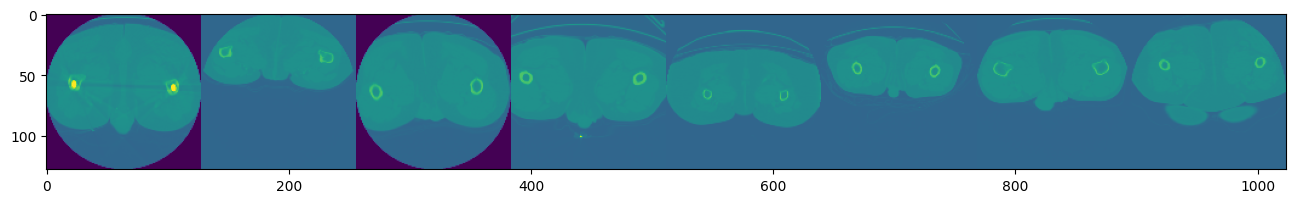

In [6]:
# -------------------------------- YOUR CODE --------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 3))
plt.imshow(torch.cat([torch.tensor(i) for i in train_X[:8, 0, :, :]], dim=-1))
# -------------------------------- YOUR CODE --------------------------------

# Utils

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
def pad_to_shape(this, shp):
    if len(shp) == 4:
        pad = (0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    elif len(shp) == 5:
        pad = (0, shp[4] - this.shape[4], 0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    return F.pad(this, pad)

Write a function that computes the dice score between a batch of prediction and ground truths.

In [9]:
def dice_score(y_pred_bin, y_true):
    """
    Args:
        y_pred_bin: shape => (batch_size, 1, h, w)
        y_true: shape => (batch_size, 1, h, w)

    Returns:
        : shape => (batch_size, dice_score)
    """

    # -------------------------------- YOUR CODE --------------------------------
    smooth = 1.0
    y_pred_flat = y_pred_bin.view(y_pred_bin.size(0), -1)
    y_true_flat = y_true.view(y_true.size(0), -1)
    intersection = torch.sum(y_pred_flat * y_true_flat, dim=1)
    union = torch.sum(y_pred_flat, dim=1) + torch.sum(y_true_flat, dim=1)
    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice
    # -------------------------------- YOUR CODE --------------------------------

# Part 1: 2D UNet

In this section we are going to use a 2D UNet to train a segmentation model.

## Part 1.1: Model Definition

First we need to implement the model architecture. The necessary modules are created in the init functions. Complete the forward method for the UNet model.

In [ ]:
class UNet2D(nn.Module):

    def __init__(self, in_channels, out_channels, conv_depths=(16, 32, 64, 128, 256)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'
        super(UNet2D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First2D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder2D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder2D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last2D(conv_depths[1], conv_depths[0], out_channels))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center2D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)

    def forward(self, x, return_all=False):

        # -------------------------------- YOUR CODE --------------------------------
        encoder_outputs = []
        for layer in self.encoder_layers:
            x = layer(x)
            encoder_outputs.append(x)

        x = self.center(x)

        for layer in self.decoder_layers:
            encoder_output = encoder_outputs.pop()
            x = layer(torch.cat([x, encoder_output], dim=1))

        return x
        # -------------------------------- YOUR CODE --------------------------------

## Part 1.2: Dataset Definition

In [ ]:
class Dataset2D(Dataset):
    def __init__(self, x, y, Normalization = False):

        self.Normalization = Normalization
        self.slices_x = []
        self.slices_y = []
        for i in range(x.shape[0]):
            for j in range(x.shape[2]):
                sx = x[i,  j, :, :]
                sy = y[i,  j, :, :]
                if sy.sum() > 0:
                    self.slices_x.append(sx)
                    self.slices_y.append(sy)

    def __len__(self):
        return len(self.slices_x) # number of samples


    def __getitem__(self, index): # sampling method. used by DataLoader.
        x = self.slices_x[index]
        y = self.slices_y[index]
        if self.Normalization:
            x = (x - x.min()) / (x.max() - x.min())
        return x, y, index # we return the index as well for future use

## Part 1.3: Train

In [ ]:
model = UNet2D(in_channels=1, out_channels=2)
model.to(device).float()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
epochs = 50

In [ ]:
train_loader = DataLoader(
    Dataset2D(train_X, train_Y, Normalization=True),
    batch_size=32,
    shuffle=True,
    num_workers=6
)

print('Train Loader Done')

valid_loader = DataLoader(
    Dataset2D(valid_X, valid_Y, Normalization=True),
    batch_size=32,
    shuffle=False,
    num_workers=6
)

print('Validation Loader Done')

samples_count = len(train_loader.dataset)
val_samples_count = len(valid_loader.dataset)

Train Loader Done
Validation Loader Done


The necesary components are created. Now write the training loop and train your model. Report validation results during training and save the training log in the notebook.

In [ ]:
# -------------------------------- YOUR CODE --------------------------------
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    t_loss = 0
    for data, target, batch_idx in train_loader:
        data, target = data.unsqueeze(1).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.to(torch.float))
        loss = criterion(output, target.long())
        t_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Print training information


    # Validation during training (you need to implement your validation loop)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        v_loss = 0
        for val_data, val_target, batch_idx in valid_loader:
            val_data, val_target = val_data.unsqueeze(1).to(device), val_target.to(device)
            val_output = model(val_data.to(torch.float))
            val_loss = criterion(val_output, val_target.long())
            v_loss += val_loss.item()
            dice = dice_score(torch.argmax(val_output, dim=1), val_target)
            # Update and print validation metrics
    print(f"Epoch {epoch+1}/{epochs}, Loss: {t_loss/len(train_loader):.4f}, Val_Loss :{v_loss/len(valid_loader):.4f}, Val_Dice: {dice.item()}")
# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')
# -------------------------------- YOUR CODE --------------------------------

Epoch 1/50, Loss: 0.1993, Val_Loss :4.9454, Val_Dice: 0.000992063492063492
Epoch 2/50, Loss: 0.1436, Val_Loss :0.3285, Val_Dice: 0.000992063492063492
Epoch 3/50, Loss: 0.1216, Val_Loss :0.7432, Val_Dice: 0.000992063492063492
Epoch 4/50, Loss: 0.1172, Val_Loss :0.1158, Val_Dice: 0.000992063492063492
Epoch 5/50, Loss: 0.1023, Val_Loss :0.1834, Val_Dice: 0.30101180438448566
Epoch 6/50, Loss: 0.0978, Val_Loss :0.1664, Val_Dice: 0.000992063492063492
Epoch 7/50, Loss: 0.0862, Val_Loss :0.1473, Val_Dice: 0.000992063492063492
Epoch 8/50, Loss: 0.0816, Val_Loss :0.2156, Val_Dice: 0.000992063492063492
Epoch 9/50, Loss: 0.0834, Val_Loss :0.1206, Val_Dice: 0.23382226056945643
Epoch 10/50, Loss: 0.0646, Val_Loss :0.1538, Val_Dice: 0.07628676470588236
Epoch 11/50, Loss: 0.0602, Val_Loss :0.1626, Val_Dice: 0.5118168389955687
Epoch 12/50, Loss: 0.0545, Val_Loss :0.0930, Val_Dice: 0.741635687732342
Epoch 13/50, Loss: 0.0516, Val_Loss :0.2383, Val_Dice: 0.6912585244885306
Epoch 14/50, Loss: 0.0556, Val_

# Part 2: 3D UNet

Now we want to use a 3D model and see if we can get better results. Complete the specified parts and train the model.

## Part 2.1: Model Definition

In [10]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, conv_depths=(16, 32, 64, 128, 256)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'

        super(UNet3D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First3D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder3D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder3D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last3D(conv_depths[1], conv_depths[0], out_channels))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center3D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)

    def forward(self, x, return_all=False):

        # -------------------------------- YOUR CODE --------------------------------
        encoder_outputs = []
        for layer in self.encoder_layers:
            x = layer(x)
            encoder_outputs.append(x)

        x = self.center(x)

        for layer in self.decoder_layers:
            encoder_output = encoder_outputs.pop()
            x = layer(torch.cat([x, encoder_output], dim=1))

        return x
        # -------------------------------- YOUR CODE --------------------------------

## Part 2.2: Dataset Definition

In [11]:
class Dataset3D(Dataset):
    def __init__(self, x, y, Normalization = False):

        self.Normalization = Normalization
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x) # number of samples


    def __getitem__(self, index): # sampling method. used by DataLoader.
        x = self.x[index]
        y = self.y[index]
        if self.Normalization:
            x = (x - x.min()) / (x.max() - x.min())
        return x, y, index # we return the index as well for future use

## Part 2.3: Train

In [12]:
model3d = UNet3D(in_channels=1, out_channels=2)
model3d = model3d.to(device).float()
model3d.train()
optimizer = torch.optim.Adam(model3d.parameters(), lr=1e-3)
epochs = 50

In [13]:
train_loader = DataLoader(
    Dataset3D(train_X, train_Y, Normalization=True),
    batch_size=1,
    shuffle=True,
    num_workers=6
)

print('Train Loader Done')

valid_loader = DataLoader(
    Dataset3D(valid_X, valid_Y, Normalization=True),
    batch_size=1,
    shuffle=False,
    num_workers=6
)

print('Validation Loader Done')



Train Loader Done
Validation Loader Done


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
# -------------------------------- YOUR CODE --------------------------------
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(epochs):
    model3d.train()  # Set the model to training mode
    t_loss = 0
    for data, target, batch_idx in train_loader:
        data, target = data.unsqueeze(1).to(device), target.to(device)
        # Forward pass
        optimizer.zero_grad()
        output = model3d(data.to(torch.float))

        loss = criterion(output, target.long())
        t_loss += loss.item()

        loss.backward()
        optimizer.step()



    # Validation during training (you need to implement your validation loop)
    #model3d.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        v_loss = 0
        for val_data, val_target, batch_idx in valid_loader:
            val_data, val_target = val_data.unsqueeze(1).to(device), val_target.to(device)
            val_output = model3d(val_data.to(torch.float))
            val_loss = criterion(val_output, val_target.long())
            v_loss += val_loss.item()
            dice = dice_score(torch.argmax(val_output, dim=1), val_target)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {t_loss/len(train_loader):.4f}, Val_Loss :{v_loss/len(valid_loader):.4f}, Val_Dice: {dice.item()}")
# Save the trained model
torch.save(model3d.state_dict(), 'unet3_model.pth')
# -------------------------------- YOUR CODE --------------------------------

Epoch 1/50, Loss: 0.7265, Val_Loss :0.5774, Val_Dice: 0.03112787637183327
Epoch 2/50, Loss: 0.5144, Val_Loss :0.4579, Val_Dice: 0.3510792521969901
Epoch 3/50, Loss: 0.4210, Val_Loss :0.3800, Val_Dice: 0.6556947969543148
Epoch 4/50, Loss: 0.3521, Val_Loss :0.3193, Val_Dice: 0.7110679575218583
Epoch 5/50, Loss: 0.2962, Val_Loss :0.2655, Val_Dice: 0.8375024780579234
Epoch 6/50, Loss: 0.2467, Val_Loss :0.2207, Val_Dice: 0.8003511927705683
Epoch 7/50, Loss: 0.2071, Val_Loss :0.1837, Val_Dice: 0.8245222732623492
Epoch 8/50, Loss: 0.1736, Val_Loss :0.1551, Val_Dice: 0.8596174006713281
Epoch 9/50, Loss: 0.1470, Val_Loss :0.1324, Val_Dice: 0.8289339623449232
Epoch 10/50, Loss: 0.1218, Val_Loss :0.1071, Val_Dice: 0.8524619310575636
Epoch 11/50, Loss: 0.0980, Val_Loss :0.0858, Val_Dice: 0.884913801634899
Epoch 12/50, Loss: 0.0791, Val_Loss :0.0754, Val_Dice: 0.8796054512532164
Epoch 13/50, Loss: 0.0661, Val_Loss :0.0629, Val_Dice: 0.8711520964440064
Epoch 14/50, Loss: 0.0578, Val_Loss :0.0550, Va

# Visualization

In the final section visualize segmentation masks for a few random slices for both 2D and 3D model

In [ ]:
# -------------------------------- YOUR CODE --------------------------------
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].permute(1, 2, 0))
        plt.axis('off')
    return plt
def show_predictions(dataloader, device, model, num=1):
    """
    Displays the first image of each of the num batches
    """
    for i, batch in enumerate(dataloader):
        IMG = batch[0].unsqueeze(1).to(device)
        MASK = batch[1].unsqueeze(1).to(device)

        pred_mask = model(IMG.float())
        mask = pred_mask.argmax(dim=1).unsqueeze(1)
        print(mask[0].shape, MASK[0].shape, IMG[0].shape)
        display([IMG[0].cpu(), MASK[0].cpu(), mask[0].cpu()]).show()

        if i >= num:
            break
# -------------------------------- YOUR CODE --------------------------------

torch.Size([1, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


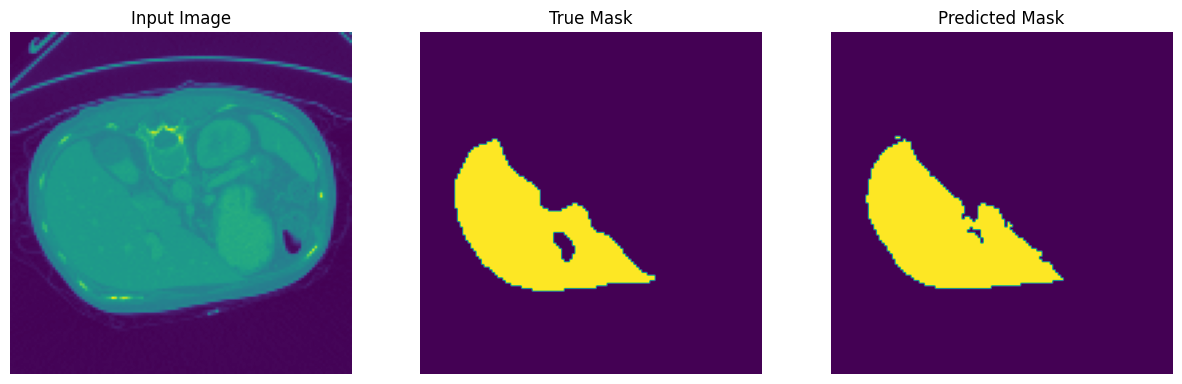

torch.Size([1, 128, 128]) torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


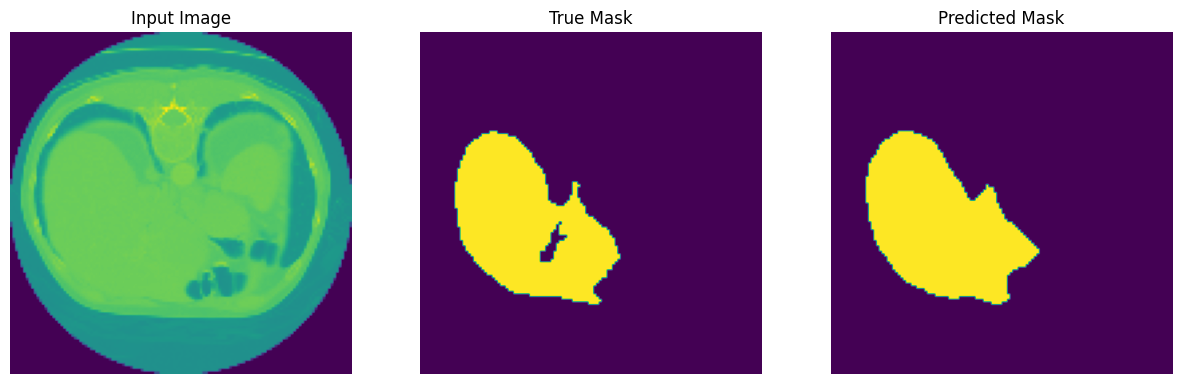

In [ ]:
show_predictions(train_loader, device, model)

In [48]:
# -------------------------------- YOUR CODE --------------------------------
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].permute(1, 2, 0))
        plt.axis('off')
    return plt
def show_predictions3d(dataloader, device, model, num=1):
    """
    Displays the first image of each of the num batches
    """
    for i, batch in enumerate(dataloader):
        IMG = batch[0].unsqueeze(1).to(device)
        MASK = batch[1].unsqueeze(1).to(device)
        with torch.no_grad():
          pred_mask = model(IMG.float())
        mask = pred_mask.argmax(dim=1).unsqueeze(1)
        display([IMG.squeeze(0,1)[100:101].cpu(), MASK.squeeze(0,1)[100:101].cpu(), mask.squeeze(0,1)[100:101].cpu()]).show()

        if i >= num:
            break
# -------------------------------- YOUR CODE --------------------------------

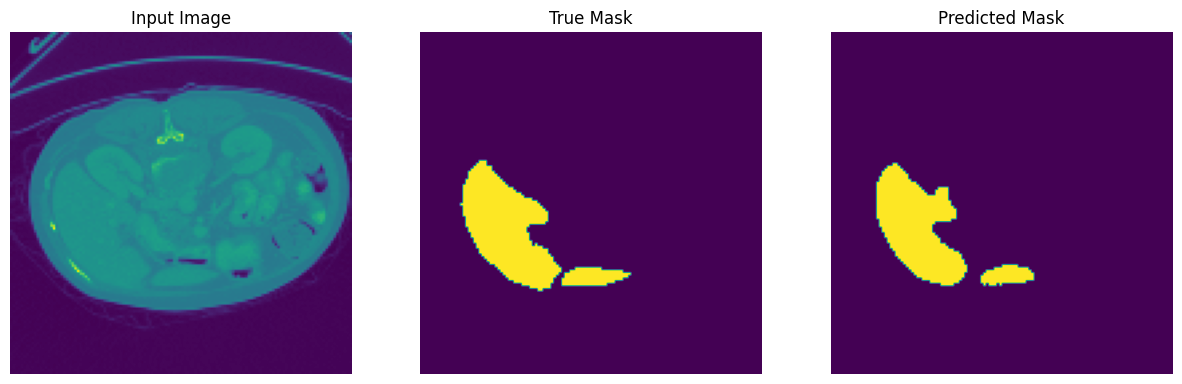

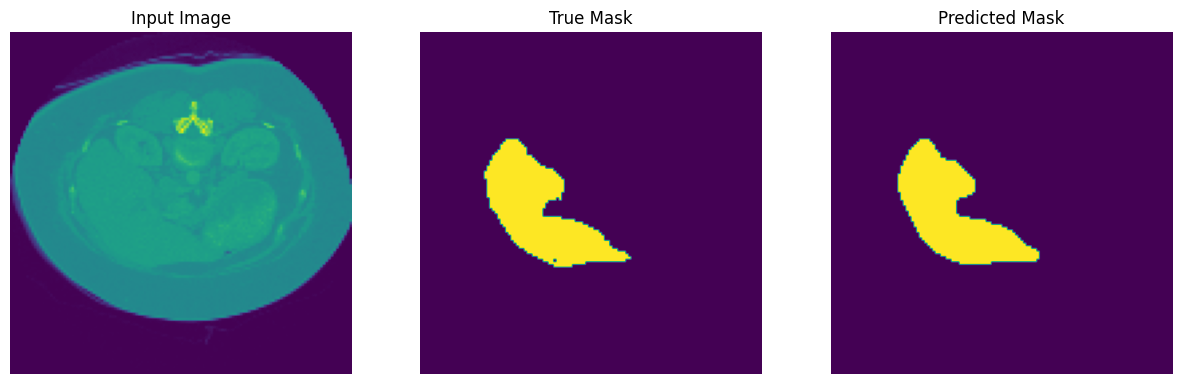

In [49]:
show_predictions3d(train_loader, device, model3d)